In [1]:
import pandas as pd
import numpy as np
import hashlib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import joblib
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from folium.plugins import HeatMap
import streamlit as st


In [3]:
df = pd.read_csv('inside_airbnb_sydney.csv')
print(df.info())  
print(df.describe())  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15548 entries, 0 to 15547
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            15548 non-null  int64  
 1   listing_url                                   15548 non-null  object 
 2   scrape_id                                     15548 non-null  float64
 3   last_scraped                                  15548 non-null  object 
 4   source                                        15548 non-null  object 
 5   name                                          15548 non-null  object 
 6   description                                   15120 non-null  object 
 7   neighborhood_overview                         8392 non-null   object 
 8   picture_url                                   15547 non-null  object 
 9   host_id                                       15548 non-null 

In [5]:
columns_to_drop = [
    'neighbourhood_group_cleansed',  
    'calendar_updated',              
    'listing_url'                    
]
df = df.drop(columns=columns_to_drop, axis=1)
print("Remaining columns after dropping:")
print(df.columns)
def hash_column(value):
    if pd.notnull(value):  
        return hashlib.sha256(str(value).encode()).hexdigest()
    return value  

df['host_name'] = df['host_name'].apply(hash_column)
df['host_id'] = df['host_id'].apply(hash_column)


Remaining columns after dropping:
Index(['id', 'scrape_id', 'last_scraped', 'source', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms',
       'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
   

In [7]:
df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].median())
df['beds'] = df['beds'].fillna(df['beds'].median())

df['room_type'] = df['room_type'].fillna(df['room_type'].mode()[0])

print("Missing values after imputation:") 
print(df[['bathrooms', 'beds', 'room_type']].isnull().sum())

print("\nSample data:")
print(df[['bathrooms', 'beds', 'room_type']].head())


Missing values after imputation:
bathrooms    0
beds         0
room_type    0
dtype: int64

Sample data:
   bathrooms  beds        room_type
0        1.0   0.0  Entire home/apt
1        3.0   1.0     Private room
2        1.5   3.0  Entire home/apt
3        3.0   1.0     Private room
4        2.5   3.0  Entire home/apt


In [9]:
df['price'] = df['price'].replace(r'[\$,]', '', regex=True).astype(float)  
df['price'] = np.log1p(df['price'])
print(df[['price']].head())


      price
0  5.225747
1  4.615121
2  5.852202
3  4.615121
4  6.602588


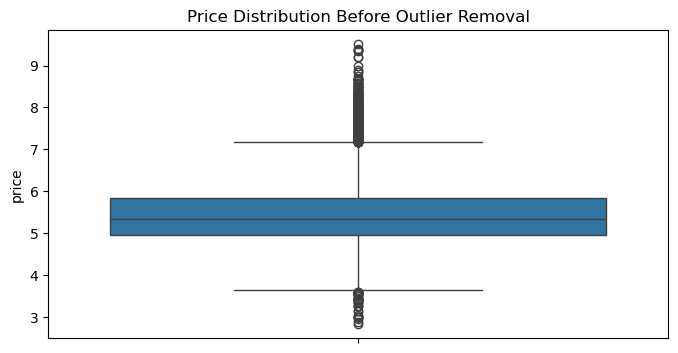

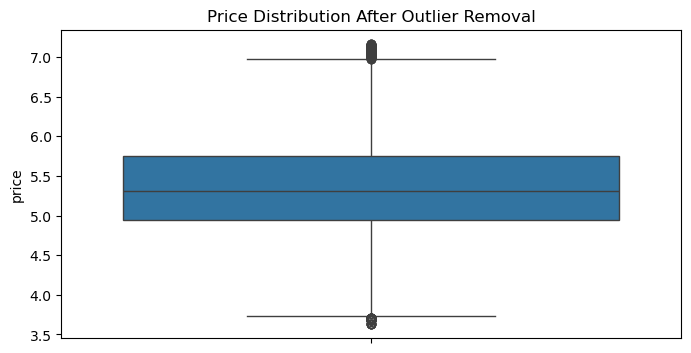

In [11]:
plt.figure(figsize=(8, 4))
sns.boxplot(df['price'])
plt.title('Price Distribution Before Outlier Removal')
plt.show()

q1, q3 = df['price'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Boxplot after removing outliers
plt.figure(figsize=(8, 4))
sns.boxplot(df['price'])
plt.title('Price Distribution After Outlier Removal')
plt.show()


In [13]:
df['price_per_bedroom'] = df['price'] / df['bedrooms']
df['reviews_per_month'] = df['number_of_reviews'] / 12
print(df[['price_per_bedroom','reviews_per_month']].head())


   price_per_bedroom  reviews_per_month
0           2.612873           0.000000
1           4.615121           8.250000
2           1.950734          17.083333
3           4.615121           3.083333
4           2.200863           3.583333


In [45]:
categorical_features = ['room_type', 'neighbourhood_cleansed']
numerical_features = ['availability_365', 'price_per_bedroom', 'reviews_per_month']

numeric_cols = numerical_features
categorical_cols = categorical_features

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


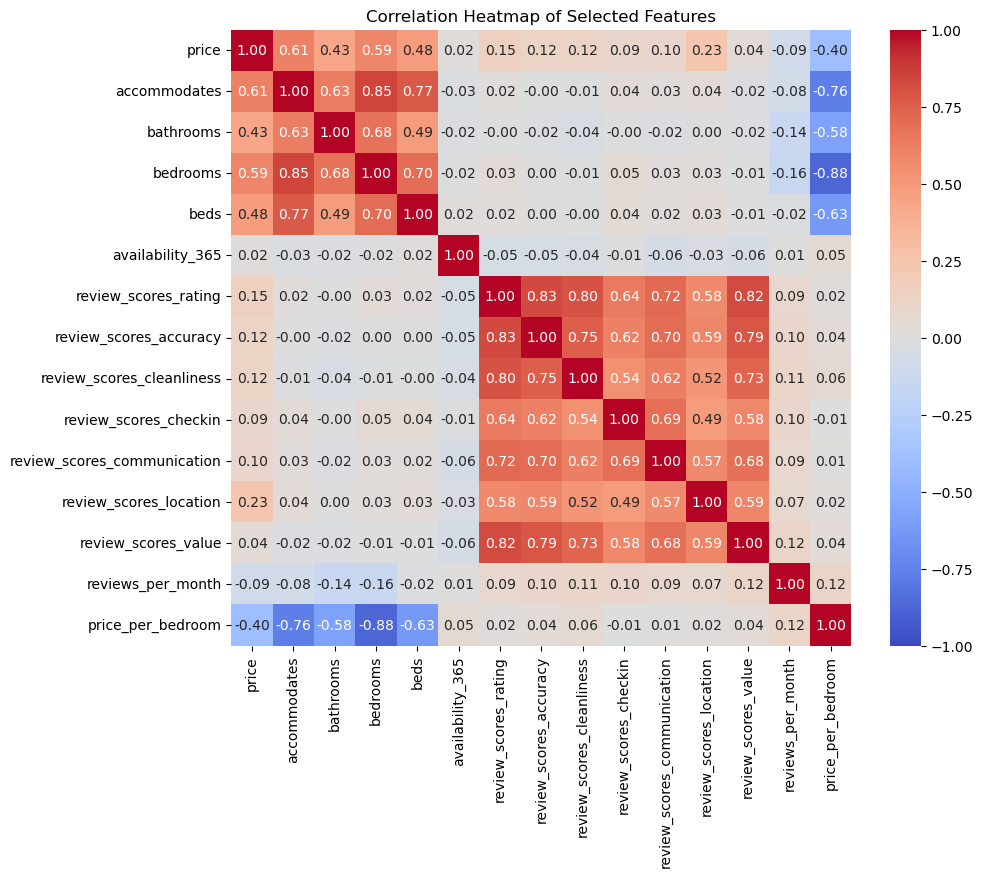

In [47]:
relevant_columns = [
    'price', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'availability_365', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'reviews_per_month', 'price_per_bedroom'
]
filtered_df = df[relevant_columns] 
correlation_matrix = filtered_df.corr()

plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Selected Features')
plt.show()


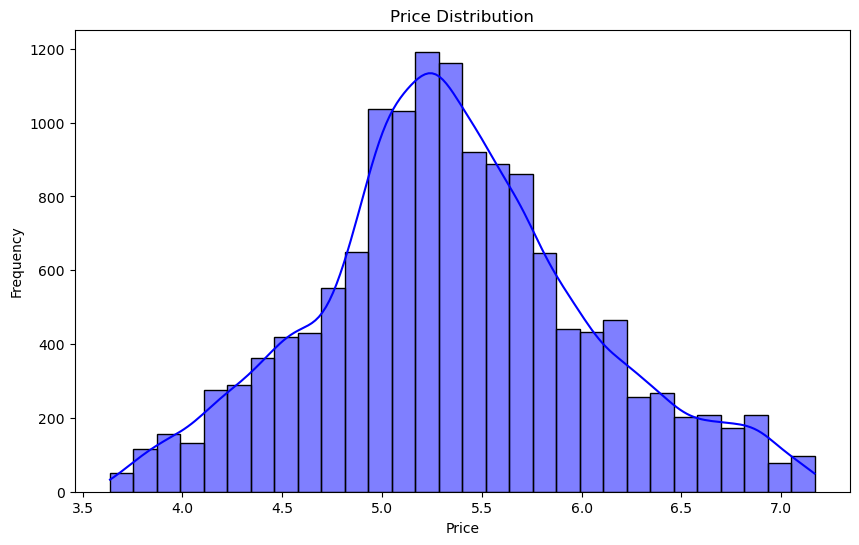

In [49]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=30, kde=True, color='blue')
plt.title('Price Distribution')
plt.xlabel('Price') 
plt.ylabel('Frequency')
plt.show()


In [51]:
neighborhood_prices = df.groupby('neighbourhood_cleansed')['price'].mean().reset_index()
neighborhood_coords = df[['neighbourhood_cleansed', 'latitude', 'longitude']].drop_duplicates()
geo_data = pd.merge(neighborhood_prices, neighborhood_coords, on='neighbourhood_cleansed')
geo_data = geo_data.dropna(subset=['latitude', 'longitude'])
sydney_map = folium.Map(location=[-33.8688, 151.2093], zoom_start=11)
heatmap_data = geo_data[['latitude', 'longitude', 'price']].values
HeatMap(heatmap_data, radius=10, blur=15, max_zoom=1).add_to(sydney_map)
sydney_map.save("sydney_neighborhood_heatmap_v2.html")
print("Geospatial heatmap saved as 'sydney_neighborhood_heatmap_v2.html'")


Geospatial heatmap saved as 'sydney_neighborhood_heatmap_v2.html'


In [53]:
X = df[['room_type', 'neighbourhood_cleansed', 'availability_365', 'price_per_bedroom', 'reviews_per_month']] 
y = df['price']

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [55]:
print("Checking for infinite values in numeric columns:")
print(np.isinf(X_train[numeric_cols]).sum())

X_train[numeric_cols] = X_train[numeric_cols].replace([np.inf, -np.inf], np.nan)
X_test[numeric_cols] = X_test[numeric_cols].replace([np.inf, -np.inf], np.nan)
X_train['price_per_bedroom'] = X_train['price_per_bedroom'].replace([np.inf, -np.inf], np.nan)
X_test['price_per_bedroom'] = X_test['price_per_bedroom'].replace([np.inf, -np.inf], np.nan)
X_train[numeric_cols] = X_train[numeric_cols].fillna(X_train[numeric_cols].median())
X_test[numeric_cols] = X_test[numeric_cols].fillna(X_test[numeric_cols].median())
print("Remaining infinite values in price_per_bedroom:")
print(np.isinf(X_train['price_per_bedroom']).sum())


Checking for infinite values in numeric columns:
availability_365       0
price_per_bedroom    674
reviews_per_month      0
dtype: int64
Remaining infinite values in price_per_bedroom:
0


In [57]:
X_train[numeric_cols] = X_train[numeric_cols].fillna(X_train[numeric_cols].median())
X_test[numeric_cols] = X_test[numeric_cols].fillna(X_test[numeric_cols].median())

X_train[categorical_cols] = X_train[categorical_cols].fillna(X_train[categorical_cols].mode().iloc[0])
X_test[categorical_cols] = X_test[categorical_cols].fillna(X_test[categorical_cols].mode().iloc[0]) 
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")


Mean Absolute Error (MAE): 0.11
R-squared (R2): 0.74


In [61]:
from sklearn.metrics import classification_report

y_train_class = pd.cut(y_train, bins=[0, y_train.quantile(0.33), y_train.quantile(0.66), y_train.max()],
                       labels=['low', 'medium', 'high'], include_lowest=True)
y_test_class = pd.cut(y_test, bins=[0, y_test.quantile(0.33), y_test.quantile(0.66), y_test.max()],
                      labels=['low', 'medium', 'high'], include_lowest=True) 
classification_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])
classification_pipeline.fit(X_train, y_train_class)
y_pred_class = classification_pipeline.predict(X_test)

accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class, average='weighted')
recall = recall_score(y_test_class, y_pred_class, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

print("Classification Report:")
print(classification_report(y_test_class, y_pred_class))


Accuracy: 0.89
Precision: 0.90
Recall: 0.89
Classification Report:
              precision    recall  f1-score   support

        high       0.80      0.97      0.88       942
         low       0.97      0.84      0.90       937
      medium       0.93      0.85      0.89       921

    accuracy                           0.89      2800
   macro avg       0.90      0.89      0.89      2800
weighted avg       0.90      0.89      0.89      2800



In [63]:
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5, 10], 
    'model__min_samples_leaf': [1, 2, 4]
}
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best MAE:", -grid_search.best_score_)
# Best model
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Tuned Mean Absolute Error (MAE): {mae:.2f}")
print(f"Tuned R-squared (R2): {r2:.2f}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Hyperparameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best MAE: 0.06166608769848242
Tuned Mean Absolute Error (MAE): 0.11
Tuned R-squared (R2): 0.74


In [65]:
import joblib
joblib.dump(best_model, "random_forest_pipeline_v2.pkl")


['random_forest_pipeline_v2.pkl']